# **References paper -**

Collaborative Filtering - https://dl.acm.org/doi/pdf/10.1145/371920.372071

Neural Collaborative Filtering - https://dl.acm.org/doi/pdf/10.1145/3038912.3052569

In [0]:
import pandas as pd
import numpy as np

# To create deep learning models
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Embedding, Reshape, Dot, Concatenate, Dense, Dropout
from keras.models import Model
from keras.utils.vis_utils import plot_model

# To stack sparse matrices
from scipy.sparse import vstack
# For visulazation
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error


In [184]:
# Load datasets
movie_ratings = pd.read_csv('/content/drive/My Drive/ml/ratings.csv')
movie_ratings.drop("timestamp", axis=1, inplace=True)
print('Shape Movie-ratings:\t{}'.format(movie_ratings.shape))
movie_ratings.head()

Shape Movie-ratings:	(100836, 3)


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


### Transform The User-Ratings To User-Movie-Matrix

In [185]:
# Create a user-movie matrix with empty values
df_p = movie_ratings.pivot_table(index='userId', columns='movieId', values='rating')
df_p.sample(6)

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,185135,185435,185473,185585,186587,187031,187541,187593,187595,187717,188189,188301,188675,188751,188797,188833,189043,189111,189333,189381,189547,189713,190183,190207,190209,190213,190215,190219,190221,191005,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
444,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
438,4.5,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179,4.0,NaN,4.0,NaN,NaN,NaN,3.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
df = movie_ratings
#create mappings
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)

df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1.
#y = df["rating"].values
y = df["rating"].apply(lambda x: (x - 0.5) / (4.5)).values

# Prepare training, validation and testing data 
# training on 90% of the data, validating on 10% and testing on 1000 seperate samples.
train_indices = int(0.9 * df.shape[0])

x_train, x_val, x_test, y_train, y_val, y_test = (
    x[:train_indices],
    x[train_indices:100000],
    x[100000:],
    y[:train_indices],
    y[train_indices:100000],
    y[100000:],
)

### create the model

In [187]:
#embed both users and movies in to 50-dimensional vectors
embedding_size= 50 

# Create model
# Set input layers
user_id_input = Input(shape=[1], name='user')
movie_id_input = Input(shape=[1], name='movie')

# Create embedding layers for users and movies
user_embedding = Embedding(output_dim=embedding_size, 
                           input_dim=num_users,
                           input_length=1, 
                           embeddings_initializer="he_normal",
                           embeddings_regularizer=keras.regularizers.l2(1e-6),
                           name='user_embedding')(user_id_input)
movie_embedding = Embedding(output_dim=embedding_size, 
                            input_dim=num_movies,
                            input_length=1, 
                            embeddings_initializer="he_normal",
                            embeddings_regularizer=keras.regularizers.l2(1e-6),
                            name='movie_embedding')(movie_id_input)

# Reshape the embedding layers
user_vector = Reshape([embedding_size])(user_embedding)
movie_vector = Reshape([embedding_size])(movie_embedding)

# Concatenate the reshaped embedding layers
concat = Concatenate()([user_vector, movie_vector])
#concat = Dot(1, normalize=False)([user_vector, movie_vector])

# Combine with dense layers
dense1 = Dense(256)(concat)
dense = Dropout(0.2)(dense1)
y = Dense(1, activation="sigmoid")(dense) # The sigmoid activation forces the rating to between 0 and 1


# compile model
model = Model(inputs=[user_id_input, movie_id_input], outputs=y)
model.compile(loss='mse',  optimizer = 'adam')
 

# Fit the model
history = model.fit(x = [x_train[:,0],x_train[:,1]],
          y = y_train,
          batch_size=256, 
          epochs=4,
          validation_data = ([x_val[:,0], x_val[:,1]], y_val),
          )

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 90752 samples, validate on 9248 samples
Epoch 1/4
90752/90752 [==============================] - 4s 42us/step - loss: 0.0413 - val_loss: 0.0388
Epoch 2/4
90752/90752 [==============================] - 4s 40us/step - loss: 0.0353 - val_loss: 0.0386
Epoch 3/4
90752/90752 [==============================] - 4s 40us/step - loss: 0.0342 - val_loss: 0.0384
Epoch 4/4
90752/90752 [==============================] - 4s 41us/step - loss: 0.0337 - val_loss: 0.0385


In [188]:
model.summary()

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
movie (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 50)        30500       user[0][0]                       
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 50)        486200      movie[0][0]                      
___________________________________________________________________________________________

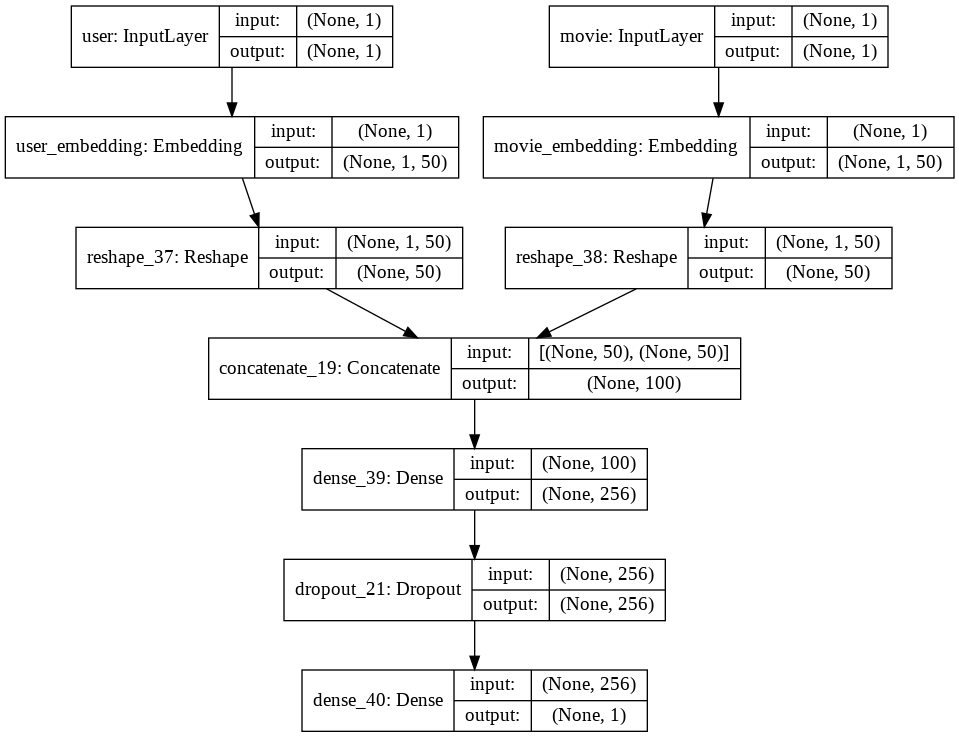

In [189]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

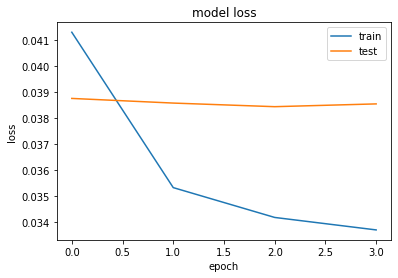

In [190]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper right")
plt.show()

In [191]:
#  Compute RMSE
y_pred = model.predict([x_test[:,0], x_test[:,1]])
y_true =  y_test

rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_true))
print('\n\nTesting Result : {:.4f} RMSE'.format(rmse))



Testing Result : 0.1987 RMSE


In [192]:
# Test model
p , a = (model.predict([x_test[:15,0], x_test[:15,1]]) , y_test[:15])
print("ratings are Normalized between 0 and 1 (0.5 - 5.0)")
for i in range(len(p)):
    print("predicted rating is : "+ str(np.round(p[i],2)) +"        actual rating was : "+ str(round(a[i],2)) )

ratings are Normalized between 0 and 1 (0.5 - 5.0)
predicted rating is : [0.66]        actual rating was : 0.78
predicted rating is : [0.69]        actual rating was : 0.78
predicted rating is : [0.9]        actual rating was : 1.0
predicted rating is : [0.49]        actual rating was : 0.44
predicted rating is : [0.64]        actual rating was : 1.0
predicted rating is : [0.66]        actual rating was : 0.56
predicted rating is : [0.45]        actual rating was : 0.56
predicted rating is : [0.84]        actual rating was : 0.78
predicted rating is : [0.38]        actual rating was : 0.33
predicted rating is : [0.64]        actual rating was : 0.78
predicted rating is : [0.58]        actual rating was : 0.33
predicted rating is : [0.49]        actual rating was : 0.33
predicted rating is : [0.85]        actual rating was : 0.78
predicted rating is : [0.7]        actual rating was : 0.67
predicted rating is : [0.82]        actual rating was : 0.89


The predictions are quite close to the actual ratings, now the model can be used to reconstruct the original matrix and to predict the missing ratings for each user.

In [0]:
movie_df = pd.read_csv('/content/drive/My Drive/ml/movies.csv')

# display recommendations
def get_recomendations(user_id):
      movies_watched_by_user = df[df.userId == user_id]
      movies_not_watched = movie_df[
          ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)]["movieId"]
      movies_not_watched = list(
          set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
      )
      movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
      user_encoder = user2user_encoded.get(user_id)
      user_movie_array = np.hstack(
          ([[user_id]] * len(movies_not_watched), movies_not_watched)
      )

      ratings = model.predict([user_movie_array[:,0], user_movie_array[:,1]]).flatten()

      top_ratings_indices = ratings.argsort()[-10:][::-1]
      recommended_movie_ids = [
          movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
      ]

      print("Showing recommendations for user: {}".format(user_id))
      print("=" * 36)
      print("Movies with high ratings from user")
      print("-" * 34)
      top_movies_user = (
          movies_watched_by_user.sort_values(by="rating", ascending=False)
          .head(5)
          .movieId.values
      )
      movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
      for row in movie_df_rows.itertuples():
          print(row.title, ":", row.genres)

      print("-" * 30)
      print(" Top 10 movie recommendations")
      print("-" * 30)
      recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
      for row in recommended_movies.itertuples():
          print(row.title, ":", row.genres)

In [194]:
#enter a user_id (between 1 - 610)
get_recomendations(1)

Showing recommendations for user: 1
Movies with high ratings from user
----------------------------------
Tommy Boy (1995) : Comedy
Tombstone (1993) : Action|Drama|Western
Three Caballeros, The (1945) : Animation|Children|Musical
Full Metal Jacket (1987) : Drama|War
Newton Boys, The (1998) : Crime|Drama
------------------------------
 Top 10 movie recommendations
------------------------------
Paths of Glory (1957) : Drama|War
Lifeboat (1944) : Drama|War
Yojimbo (1961) : Action|Adventure
Man Bites Dog (C'est arrivé près de chez vous) (1992) : Comedy|Crime|Drama|Thriller
Witness for the Prosecution (1957) : Drama|Mystery|Thriller
Neon Genesis Evangelion: The End of Evangelion (Shin seiki Evangelion Gekijô-ban: Air/Magokoro wo, kimi ni) (1997) : Action|Animation|Drama|Fantasy|Sci-Fi
Submarine (2010) : Comedy|Drama|Romance
Day of the Doctor, The (2013) : Adventure|Drama|Sci-Fi
Captain Fantastic (2016) : Drama
Three Billboards Outside Ebbing, Missouri (2017) : Crime|Drama
